<a href="https://colab.research.google.com/github/mjjuhasz/Canvasback/blob/master/DED_Process_Parameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DED Process Parameter Notebook**

=========================================================================
Load Specialized Packages (Bayesian Optimization)
=========================================================================

In [ ]:
pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

=========================================================================
Load Data and Perform Preprocessing
=========================================================================

In [ ]:
# Load dataset from GitHub Repo
Git_Dataset = "https://raw.githubusercontent.com/mjjuhasz/Canvasback/master/DED_Database.csv"

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.keras.backend.clear_session() 
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
import seaborn as sns
import matplotlib.font_manager

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split, StratifiedKFold
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, IsolationForest
from sklearn.gaussian_process import GaussianProcessRegressor, GaussianProcessClassifier 
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn import svm

In [ ]:
Full_df = pd.read_csv(Git_Dataset)

**Graph Histograms of Initial Data**

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(16, 6), tight_layout=True)
ax1.hist(Full_df['Power (W)'], density=True, color='tab:orange', edgecolor='k')
#ax1.grid()
ax1.set_ylabel('Density', weight='bold')
ax1.set_xlabel('Power (W)', weight='bold' )
ax2.hist(Full_df['Mass Flowrate (g/min)'], density=True, color='tab:orange', edgecolor='k')
#ax2.grid()
ax2.set_xlabel('Mass Flowrate (g/min)', weight='bold')
ax3.hist(Full_df['Traverse Velocity (mm/min)'], density=True, color='tab:orange', edgecolor='k')
#ax3.grid()
ax3.set_xlabel('Traverse Velocity (mm/min)', weight='bold')
ax4.hist(Full_df['Height (mm)'], density=True, color='tab:orange', edgecolor='k')
#ax4.grid()
ax4.set_xlabel('Height (mm)', weight='bold')
ax5.hist(Full_df['Width (mm)'], density=True, color='tab:orange', edgecolor='k')
#ax5.grid()
ax5.set_xlabel('Width (mm)', weight='bold')
ax6.hist(Full_df['Aspect Ratio (H/W)'], density=True, color='tab:orange', edgecolor='k')
#ax6.grid()
ax6.set_xlabel('Aspect Ratio (H/W)', weight='bold')
plt.savefig('Dataset.png', dpi=600)
plt.show()

**Prepare Full and PH 13-8 Datasets**

In [ ]:
Math = 60 * (Full_df['Power (W)']/Full_df['Traverse Velocity (mm/min)'])
LHI = pd.Series(Math, name='Linear Heat Input (J/mm)')
df1 = Full_df.join(LHI)
PHdf1 = df1[df1['Author/Paper']=='Juhasz'] # Filter on my research
FullDS = df1.drop(columns=['Author/Paper', 'Height (mm)', 'Width (mm)', 'Contact Angle (deg)'])
FullDS.dropna(subset=['Aspect Ratio (H/W)'], inplace=True)
PHDS = PHdf1.drop(columns=['Author/Paper', 'Powder Material', 'Substrate Material', 'Spot Size (mm)', 'Power (W)',
                           'Traverse Velocity (mm/min)', 'Contact Angle (deg)'])

**Graph Histograms of Preprocessed Data**
* Numeric Only - Power Transformed

In [ ]:
FullDSPF = df1.drop(columns=['Author/Paper', 'Powder Material', 'Substrate Material',
       'Spot Size (mm)', 'Contact Angle (deg)'])
PT = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
P = PT.fit_transform(FullDSPF)
PFDF = pd.DataFrame(P, columns=['Power (W)', 'Mass Flowrate (g/min)', 'Traverse Velocity (mm/min)',
       'Height (mm)', 'Width (mm)', 'Aspect Ratio (H/W)',
       'Linear Heat Input (J/mm)'])

In [ ]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 6), tight_layout=True)
ax1.hist(PFDF['Linear Heat Input (J/mm)'], density=True, color='tab:blue', edgecolor='k')
ax1.set_ylabel('Density', weight='bold')
ax1.set_xlabel('Linear Heat Input (J/mm)', weight='bold' )
ax2.hist(PFDF['Mass Flowrate (g/min)'], density=True, color='tab:blue', edgecolor='k')
ax2.set_xlabel('Mass Flowrate (g/min)', weight='bold')
ax3.hist(PFDF['Height (mm)'], density=True, color='tab:blue', edgecolor='k')
ax3.set_xlabel('Height (mm)', weight='bold')
ax4.hist(PFDF['Width (mm)'], density=True, color='tab:blue', edgecolor='k')
ax4.set_xlabel('Width (mm)', weight='bold')
ax5.hist(PFDF['Aspect Ratio (H/W)'], density=True, color='tab:blue', edgecolor='k')
ax5.set_xlabel('Aspect Ratio (H/W)', weight='bold')
plt.savefig('PTDataset.png', dpi=600)
plt.show()

In [ ]:
sod = StandardScaler()
PlotDat = sod.fit_transform(FullDS[['Linear Heat Input (J/mm)','Mass Flowrate (g/min)','Aspect Ratio (H/W)']])
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
ax1.set_title("Scaled Original Data", weight='bold')
ax1.scatter(PlotDat[:,0],PlotDat[:,2], color='gold', edgecolors='k')
ax1.scatter(PlotDat[:,1],PlotDat[:,2], color='violet', edgecolors='k')
ax1.set_ylabel("Aspect Ratio (H/W)", weight='bold')
ax1.set_xlabel("Linear Heat Input/Mass Flow Rate , a.u.", weight='bold')
ax1.legend(("Linear Heat Input","Mass Flowrate"))
ax2.set_title("Power-Transformed and Scaled Data", weight='bold')
ax2.scatter(PFDF['Linear Heat Input (J/mm)'],PFDF['Aspect Ratio (H/W)'], color='violet', edgecolors='k')
ax2.scatter(PFDF['Mass Flowrate (g/min)'],PFDF['Aspect Ratio (H/W)'], color='gold', edgecolors='k')
ax2.set_xlabel("Linear Heat Input/Mass Flow Rate , a.u.", weight='bold')
ax2.legend(('Linear Heat Input','Mass Flowrate'))
plt.savefig('OrgtoPTDataset.png', dpi=600)
plt.show()

**Split Data into X, y and build Pipeline**

In [ ]:
# Shuffle and Split Data
FullDS = shuffle(FullDS, random_state=7)
X = FullDS.drop(columns='Aspect Ratio (H/W)')
y = FullDS['Aspect Ratio (H/W)']

In [ ]:
Impute_Features = ['Spot Size (mm)']
Numeric_Features = ['Mass Flowrate (g/min)', 'Linear Heat Input (J/mm)']
Categorical_Features = ['Powder Material', 'Substrate Material']
impute_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
power_transformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
input_trans=[('impute', impute_transformer , Impute_Features),
      ('num', power_transformer, Numeric_Features),
      ('cat', OneHotEncoder(), Categorical_Features)]
test_trans=[('impute', impute_transformer , Impute_Features),
      ('num', 'passthrough', Numeric_Features),
      ('cat', OneHotEncoder(), Categorical_Features)]
Input_preprocessor = ColumnTransformer(transformers=input_trans)
Output_preprocessor = power_transformer
Test_preprocessor = ColumnTransformer(transformers=test_trans)

In [ ]:
Xrc = Input_preprocessor.fit_transform(X)
yr = Output_preprocessor.fit_transform(y.values.reshape(-1,1))
Xr_train, Xr_test, yr_train, yr_test = train_test_split(Xrc, yr, test_size=.2)

In [ ]:
bins = pd.IntervalIndex.from_tuples([(-.01, .375), (.375, .425), (.425, .475), (.475,.525), (.525,.575), (.575,.625), (.625,2.9)])
AR = pd.cut(y, bins=bins)
AR1 = AR.to_numpy()
LE = preprocessing.LabelEncoder()
OHE = preprocessing.OneHotEncoder()
yc = LE.fit_transform(AR)
ycn = OHE.fit_transform(AR1.reshape(-1,1))
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xrc, yc, test_size=.2)
Xcn_train, Xcn_test, ycn_train, ycn_test = train_test_split(Xrc, ycn, test_size=.2)

In [ ]:
xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
ones = np.ones((xx.ravel().shape[0],1))
PM = np.array(['PH13-8']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM = np.array(['Stainless Steel']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
Spot_Size = .75
TestDF = pd.DataFrame(np.column_stack(tup=[PM, SM, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
Test_preprocessor.fit(X)
rcTest = Test_preprocessor.transform(TestDF)    

=========================================================================
Neural Net Hyperparameter Optimization
=========================================================================

In [ ]:
# Bounded region of parameter space
pbounds = {'Alpha':(.1,.6),'Epsilon':(.0001,.001),'LNodes':(200,750),'LR':(.00001,.001),
           'Momentum':(.05,.2),'NLNodes':(200,1000),'NodeShrink':(.1,1),'NumLayers':(1,3)}
optimizer = BayesianOptimization(f=HPc,pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=21)

In [ ]:
optimizer.maximize(init_points=0,n_iter=10)

In [ ]:
def HP(Alpha,Epsilon,LNodes,LR,Momentum,NLNodes, NodeShrink, NumLayers):
  Ridge = 0.0
  Lasso = 0.0
  #Momentum = .1
  #Epsilon = .005
  #Alpha = 1.0
  #LR = .001
  #NumLayers = 1
  #NodeShrink = 1
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Xrc.shape[1],))
  # Nonlinear Network
  NL = layers.Dense(np.round(NLNodes).astype('int'), activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,np.round(NumLayers).astype('int')):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink).astype('int'), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(np.round(LNodes).astype('int'),activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(1, activation=tf.keras.activations.linear, use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  Opt = tf.keras.optimizers.Adam(learning_rate=LR)
  #Loss = tf.keras.losses.MeanSquaredLogarithmicError()
  Loss = tf.keras.losses.MeanSquaredError()
  model.compile(optimizer=Opt,loss=Loss)
  Scores = list()
  nfolds = 5
  kf = KFold(nfolds, shuffle=True, random_state=21)
  fold = 0
  for train, test in kf.split(Xrc.toarray()):
    fold+=1        
    x_train = Xrc[train].toarray()
    y_train = yr[train]
    x_test = Xrc[test].toarray()
    y_test = yr[test]
    Report = model.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],batch_size=np.round(Xrc.shape[0]*.01).astype('int'),epochs=50,verbose=0,shuffle=True)
    pred = model.predict(x_test)    
    score = mean_squared_error(y_test,pred,squared=False)
    Scores.append(score)
  negmean = -1 * np.mean(Scores)
  return negmean

In [ ]:
def HPc(Alpha,Epsilon,LNodes,LR,Momentum,NLNodes, NodeShrink, NumLayers):
  Ridge = 0.0
  Lasso = 0.0
  #Momentum = .1
  #Epsilon = .005
  #Alpha = 1.0
  #LR = .001
  #NumLayers = 1
  #NodeShrink = 1
  #LNodes = 64
  #NLNodes = 64
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Xrc.shape[1],))
  # Nonlinear Network
  NL = layers.Dense(np.round(NLNodes).astype('int'), activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,np.round(NumLayers).astype('int')):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink).astype('int'), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(np.round(LNodes).astype('int'),activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(ycn.shape[1], activation=tf.keras.activations.softmax, use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  Opt = tf.keras.optimizers.Adam(learning_rate=LR)
  Loss = tf.keras.losses.CategoricalCrossentropy()
  model.compile(optimizer=Opt,loss=Loss)
  Scores = list()
  nfolds = 5
  kf = KFold(nfolds, shuffle=True, random_state=21)
  fold = 0
  for train, test in kf.split(Xrc.toarray()):
    fold+=1        
    x_train = Xrc[train].toarray()
    y_train = ycn[train].toarray()
    x_test = Xrc[test].toarray()
    y_test = ycn[test].toarray()
    Report = model.fit(x=x_train,y=y_train,validation_data=[x_test,y_test],batch_size=np.round(Xrc.shape[0]*.01).astype('int'),epochs=50,verbose=0,shuffle=True)
    pred = model.predict(x_test)
    m = tf.keras.metrics.CategoricalCrossentropy()
    _ = m.update_state(tf.convert_to_tensor(y_test),pred)
    Scores.append(m.result().numpy())
  negmean = -1 * np.mean(Scores)
  return negmean

=========================================================================
Neural Nets
=========================================================================

In [ ]:
def build_regressor(NLNodes,NumLayers,LNodes):
  Ridge = 0.0
  Lasso = 0.0
  Momentum = .09014
  Epsilon = .000577
  Alpha = .3088
  NodeShrink = .7846
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Xrc.shape[1],))
  # Nonlinear Network
  NL = layers.Dense(NLNodes, activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,NumLayers):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(LNodes,activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(1, activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  #outputs = layers.Dense(1, activation=tf.keras.activations.exponential, use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
Regressor = build_regressor(210,1,283)

In [ ]:
keras.utils.plot_model(Regressor, show_shapes=True)

In [ ]:
Opt = tf.keras.optimizers.Adam(learning_rate=.000871)
#Loss = tf.keras.losses.MeanSquaredLogarithmicError()
Loss = tf.keras.losses.MeanSquaredError()
#def scheduler(epoch):
  #if epoch < 10:
    #return 0.0001
  #if epoch >= 10 and epoch < 25:
    #return .0013
  #else:
    #return 0.0013 * tf.math.exp(0.1 * (25 - epoch))
#LRS = tf.keras.callbacks.LearningRateScheduler(scheduler) 
Monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=100,mode='min',restore_best_weights=True)
Regressor.compile(optimizer=Opt,loss=Loss)

In [ ]:
History = Regressor.fit(x=Xrc.toarray(),y=yr,batch_size=np.round(Xrc.shape[0]*.01).astype('int'),epochs=500,callbacks=[Monitor],verbose=1,validation_split=.2,shuffle=True)

In [ ]:
Regressor.save('DEDNNr.h5',save_format='h5')

In [ ]:
def build_classifier(NLNodes,NumLayers,LNodes):
  Ridge = 0.0
  Lasso = 0.0
  Momentum = .1156
  Epsilon = .000841
  Alpha = .2029
  NodeShrink = .6985
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Xrc.shape[1],))
  # Nonlinear Network
  NL = layers.Dense(NLNodes, activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,NumLayers):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(LNodes,activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(ycn.shape[1], activation=tf.keras.activations.softmax, use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
Classifier = build_classifier(744,1,358)

In [ ]:
keras.utils.plot_model(Classifier, show_shapes=True)

In [ ]:
Optc = tf.keras.optimizers.Adam(learning_rate=.000465)
Lossc = tf.keras.losses.CategoricalCrossentropy()
#def scheduler(epoch):
  #if epoch < 10:
    #return 0.0001
  #if epoch >= 10 and epoch < 25:
    #return .0013
  #else:
    #return 0.0013 * tf.math.exp(0.1 * (25 - epoch))
#LRS = tf.keras.callbacks.LearningRateScheduler(scheduler) 
Monitor = tf.keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=100,mode='min',restore_best_weights=True)
Classifier.compile(optimizer=Optc,loss=Lossc)

In [ ]:
Historyc = Classifier.fit(x=Xrc.toarray(),y=ycn.toarray(),batch_size=np.round(Xrc.shape[0]*.01).astype('int'),epochs=500,callbacks=[Monitor],verbose=1,validation_split=.2,shuffle=True)

In [ ]:
nnr_score = Regressor.predict(Xr_test.toarray())
r2NN = r2_score(yr_test,nnr_score)
r2NN

In [ ]:
nnc_score = Classifier.predict(Xcn_test.toarray())
r2NNc = accuracy_score(np.argmax(ycn_test, axis=1),np.argmax(nnc_score, axis=1))
r2NNc

In [ ]:
nn_y_pred = Regressor.predict(rcTest.toarray())
nnr_pred = Regressor.predict(Xrc.toarray())

In [ ]:
nnc_y_pred = Classifier.predict(rcTest.toarray())
nnc_pred = Classifier.predict(Xrc.toarray())
nnc_y_pred = np.argmax(nnc_y_pred, axis=1)
nnc_pred = np.argmax(nnc_pred, axis=1)

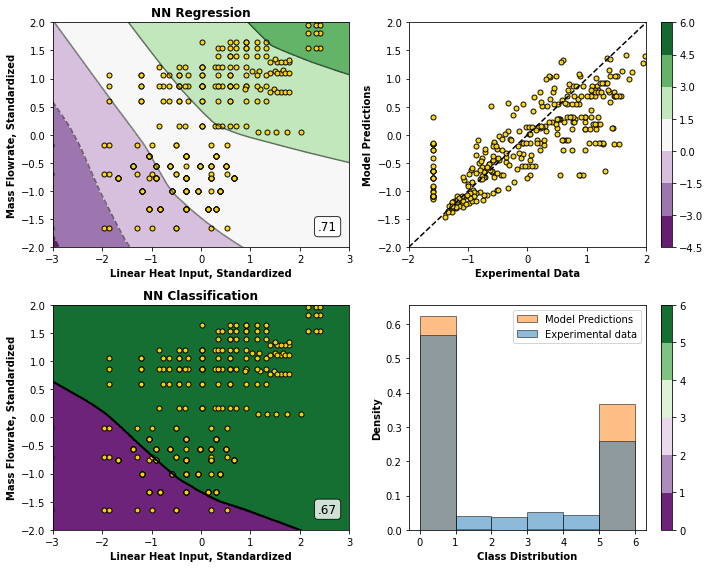

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
ax1.set_title("NN Regression", weight='bold')
CS1 = ax1.contourf(xx, yy, nn_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax1.contour(CS1, levels=CS1.levels, colors='k', alpha=.5)
fig.colorbar(CS1, ax=ax2)
ax1.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax1.text(2.75, -1.75, ('%.2f' % r2NN).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax1.set_xlim(-3,3)
ax1.set_ylim(-2,2)
ax1.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax1.set_ylabel('Mass Flowrate, Standardized', weight='bold')
ax2.scatter(yr, nnr_pred, c='gold', s=25, edgecolors='k', alpha=.95)
ax2.plot([-2,2],[-2,2], '--k')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.set_xlabel('Experimental Data', weight='bold')
ax2.set_ylabel('Model Predictions', weight='bold')

ax3.set_title("NN Classification", weight='bold')
CS2 = ax3.contourf(xx, yy, nnc_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax3.contour(CS2, levels=CS2.levels, colors='k', alpha=.5)
fig.colorbar(CS2, ax=ax4)
ax3.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax3.text(2.75, -1.75, ('%.2f' % r2NNc).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax3.set_xlim(-3,3)
ax3.set_ylim(-2,2)
ax3.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax3.set_ylabel('Mass Flowrate, Standardized', weight='bold')

ax4.hist(nnc_pred, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax4.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax4.set_xlabel('Class Distribution', weight='bold')
ax4.set_ylabel('Density', weight='bold')
ax4.legend(('Model Predictions','Experimental data'))
plt.savefig('NNresults.png', dpi=600)
plt.show()

=========================================================================
Gaussian Processes
=========================================================================

Instantiate a Gaussian Process model

In [ ]:
kernel = (ConstantKernel() * RBF() + WhiteKernel()) + (ConstantKernel() * RBF() + WhiteKernel())
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=50, random_state=21)
gpr.fit(Xr_train.toarray(), yr_train)
gpr_score = gpr.predict(Xr_test.toarray())
r2GPr = r2_score(yr_test, gpr_score)
r2GPr

In [ ]:
ckernel = (ConstantKernel() * RBF() + WhiteKernel()) + (ConstantKernel() * RBF() + WhiteKernel())
gpc = GaussianProcessClassifier(kernel=ckernel, multi_class='one_vs_one', n_restarts_optimizer=10, max_iter_predict=500, random_state=21)
gpc.fit(Xc_train.toarray(),yc_train)
gpc_score = gpc.predict(Xc_test.toarray())
r2GPc = accuracy_score(yc_test, gpc_score)
r2GPc

In [ ]:
gpr_y_pred = gpr.predict(rcTest.toarray())
gpr_score = gpr.predict(Xrc.toarray())

In [ ]:
gpc_y_pred = gpc.predict(rcTest.toarray())
gpc_score = gpc.predict(Xrc.toarray())

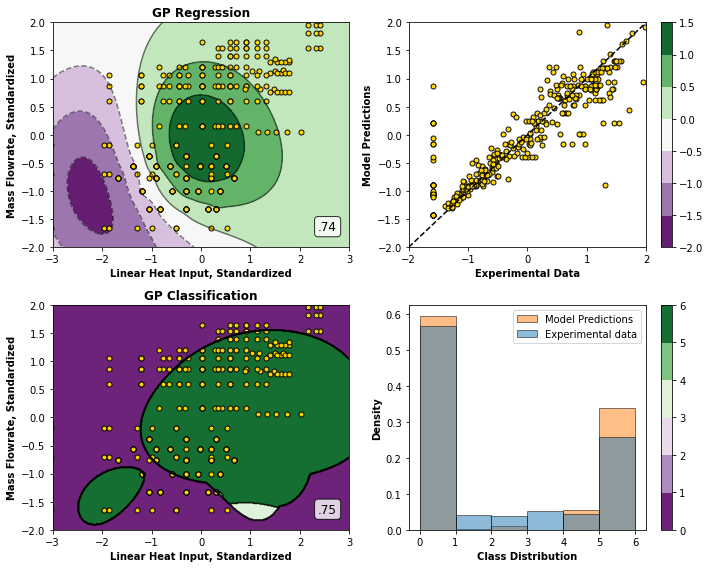

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
ax1.set_title("GP Regression", weight='bold')
CS1 = ax1.contourf(xx, yy, gpr_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax1.contour(CS1, levels=CS1.levels, colors='k', alpha=.5)
fig.colorbar(CS1, ax=ax2)
ax1.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax1.text(2.75, -1.75, ('%.2f' % r2GPr).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax1.set_xlim(-3,3)
ax1.set_ylim(-2,2)
ax1.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax1.set_ylabel('Mass Flowrate, Standardized', weight='bold')
ax2.scatter(yr, gpr_score, c='gold', s=25, edgecolors='k', alpha=.95)
ax2.plot([-2,2],[-2,2], '--k')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.set_xlabel('Experimental Data', weight='bold')
ax2.set_ylabel('Model Predictions', weight='bold')

ax3.set_title("GP Classification", weight='bold')
CS2 = ax3.contourf(xx, yy, gpc_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax3.contour(CS2, levels=CS2.levels, colors='k', alpha=.5)
fig.colorbar(CS2, ax=ax4)
ax3.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax3.text(2.75, -1.75, ('%.2f' % r2GPc).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax3.set_xlim(-3,3)
ax3.set_ylim(-2,2)
ax3.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax3.set_ylabel('Mass Flowrate, Standardized', weight='bold')

ax4.hist(gpc_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax4.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax4.set_xlabel('Class Distribution', weight='bold')
ax4.set_ylabel('Density', weight='bold')
ax4.legend(('Model Predictions','Experimental data'))
plt.savefig('GPresults.png', dpi=600)
plt.show()

=========================================================================
Support Vector Machines
=========================================================================

In [ ]:
from sklearn import svm
SVR = svm.SVR(kernel='rbf',gamma='scale',C=5)
SVR.fit(Xr_train.toarray(),yr_train)
svr_score = SVR.predict(Xr_test.toarray())
r2SVR = r2_score(yr_test,svr_score)
r2SVR

In [ ]:
SVR_y_pred = SVR.predict(rcTest.toarray())
svr_score = SVR.predict(Xrc.toarray())

In [ ]:
SVMC = svm.SVC(kernel='rbf',gamma='scale',C=12, random_state=21)
SVMC.fit(Xc_train.toarray(),yc_train)
svmc_score = SVMC.predict(Xc_test.toarray())
r2SVMC = accuracy_score(yc_test,svmc_score)
r2SVMC

In [ ]:
SVC_y_pred = SVMC.predict(rcTest.toarray())
svmc_score = SVMC.predict(Xrc.toarray())

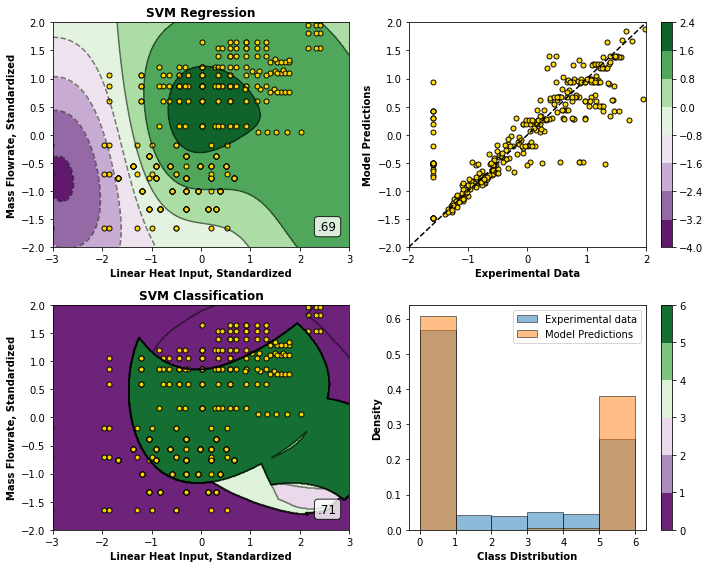

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
ax1.set_title("SVM Regression", weight='bold')
CS1 = ax1.contourf(xx, yy, SVR_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax1.contour(CS1, levels=CS1.levels, colors='k', alpha=.5)
fig.colorbar(CS1, ax=ax2)
ax1.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax1.text(2.75, -1.75, ('%.2f' % r2SVR).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax1.set_xlim(-3,3)
ax1.set_ylim(-2,2)
ax1.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax1.set_ylabel('Mass Flowrate, Standardized', weight='bold')
ax2.scatter(yr, svr_score, c='gold', s=25, edgecolors='k', alpha=.95)
ax2.plot([-2,2],[-2,2], '--k')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.set_xlabel('Experimental Data', weight='bold')
ax2.set_ylabel('Model Predictions', weight='bold')

ax3.set_title("SVM Classification", weight='bold')
CS2 = ax3.contourf(xx, yy, SVC_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax3.contour(CS2, levels=CS2.levels, colors='k', alpha=.5)
fig.colorbar(CS2, ax=ax4)
ax3.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax3.text(2.75, -1.75, ('%.2f' % r2SVMC).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax3.set_xlim(-3,3)
ax3.set_ylim(-2,2)
ax3.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax3.set_ylabel('Mass Flowrate, Standardized', weight='bold')

ax4.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax4.hist(svmc_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax4.set_xlabel('Class Distribution', weight='bold')
ax4.set_ylabel('Density', weight='bold')
ax4.legend(('Experimental data','Model Predictions'))
plt.savefig('SVMresults.png', dpi=600)
plt.show()

=========================================================================
Boosted Trees
=========================================================================

In [ ]:
rGBT = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=20, random_state=21, loss='ls')
rGBT.fit(Xr_train.toarray(),yr_train)
rGBT_score = rGBT.predict(Xr_test.toarray())
r2rGBT = r2_score(yr_test, rGBT_score)
r2rGBT

In [ ]:
rGBT_y_pred = rGBT.predict(rcTest.toarray())
rGBT_score = rGBT.predict(Xrc.toarray())

In [ ]:
cGBT = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth=20, random_state=21, loss='deviance')
cGBT.fit(Xc_train.toarray(),yc_train)
cGBT_score = cGBT.predict(Xc_test.toarray())
r2cGBT = accuracy_score(yc_test, cGBT_score)
r2cGBT

In [ ]:
cGBT_y_pred = cGBT.predict(rcTest.toarray())
cGBT_score = cGBT.predict(Xrc.toarray())

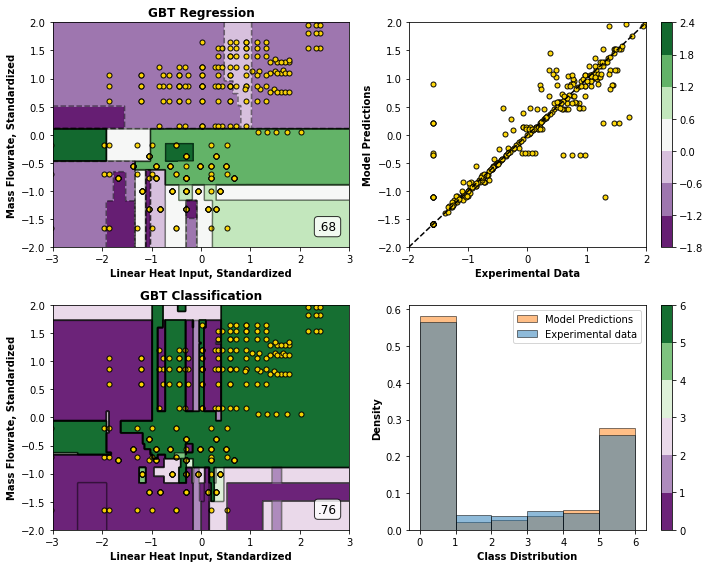

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8), tight_layout=True)
ax1.set_title("GBT Regression", weight='bold')
CS1 = ax1.contourf(xx, yy, rGBT_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax1.contour(CS1, levels=CS1.levels, colors='k', alpha=.5)
fig.colorbar(CS1, ax=ax2)
ax1.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax1.text(2.75, -1.75, ('%.2f' % r2rGBT).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax1.set_xlim(-3,3)
ax1.set_ylim(-2,2)
ax1.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax1.set_ylabel('Mass Flowrate, Standardized', weight='bold')
ax2.scatter(yr, rGBT_score, c='gold', s=25, edgecolors='k', alpha=.95)
ax2.plot([-2,2],[-2,2], '--k')
ax2.set_xlim(-2,2)
ax2.set_ylim(-2,2)
ax2.set_xlabel('Experimental Data', weight='bold')
ax2.set_ylabel('Model Predictions', weight='bold')

ax3.set_title("GBT Classification", weight='bold')
CS2 = ax3.contourf(xx, yy, cGBT_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax3.contour(CS2, levels=CS2.levels, colors='k', alpha=.5)
fig.colorbar(CS2, ax=ax4)
ax3.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax3.text(2.75, -1.75, ('%.2f' % r2cGBT).lstrip('0'), size=12,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax3.set_xlim(-3,3)
ax3.set_ylim(-2,2)
ax3.set_xlabel('Linear Heat Input, Standardized', weight='bold')
ax3.set_ylabel('Mass Flowrate, Standardized', weight='bold')

ax4.hist(cGBT_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax4.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax4.set_xlabel('Class Distribution', weight='bold')
ax4.set_ylabel('Density', weight='bold')
ax4.legend(('Model Predictions','Experimental data'))
plt.savefig('GBTresults.png', dpi=600)
plt.show()

=========================================================================
Literature Regression and Summary Plot
=========================================================================

Literature Regression with Height as Response

In [ ]:
LRH = Full_df.dropna(subset=['Height (mm)'])

In [ ]:
Wu = LRH['Mass Flowrate (g/min)']/LRH['Traverse Velocity (mm/min)']
Felde = ((LRH['Power (W)'] * LRH['Mass Flowrate (g/min)'])**(.5))/LRH['Traverse Velocity (mm/min)']
ElCh = ((LRH['Power (W)']**(.25)) * (LRH['Mass Flowrate (g/min)']**(.75)))/LRH['Traverse Velocity (mm/min)']
Ansari = ((LRH['Power (W)']**2) * LRH['Mass Flowrate (g/min)'])/(LRH['Traverse Velocity (mm/min)']**1.5)

In [ ]:
SS = StandardScaler()
Wu = SS.fit_transform(Wu.values.reshape(-1,1))
Felde = SS.fit_transform(Felde.values.reshape(-1,1))
ElCh = SS.fit_transform(ElCh.values.reshape(-1,1))
Ansari = SS.fit_transform(Ansari.values.reshape(-1,1))
H = SS.fit_transform(LRH['Height (mm)'].values.reshape(-1,1))

In [ ]:
r1 = r2_score(H,Wu)
r2 = r2_score(H,Felde)
r3 = r2_score(H,ElCh)
r4 = r2_score(H,Ansari)
r1, r2, r3, r4

(-0.570042159267492,
 0.4064499349848526,
 -0.0651640570460057,
 0.3842571222813139)

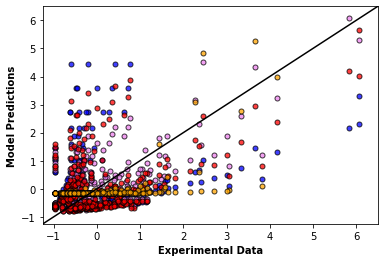

In [ ]:
plt.scatter(H,Wu, c='blue', s=25, edgecolors='k', alpha=.75)
plt.scatter(H,Felde, c='violet', s=25, edgecolors='k', alpha=.75)
plt.scatter(H,ElCh, c='red', s=25, edgecolors='k', alpha=.75)
plt.scatter(H,Ansari, c='orange', s=25, edgecolors='k', alpha=.75)
plt.plot([-2,12],[-2,12], c='k')
plt.xlim(-1.25,6.5)
plt.ylim(-1.25,6.5)
plt.xlabel('Experimental Data', weight='bold')
plt.ylabel('Model Predictions', weight='bold')
plt.show()

Literature Regression with Aspect Ratio as Response

In [ ]:
LRAR = Full_df.dropna(subset=['Aspect Ratio (H/W)'])

In [ ]:
Ocelik = LRAR['Mass Flowrate (g/min)']/(LRAR['Power (W)'] * LRAR['Traverse Velocity (mm/min)']**(.5))
ElCh =  LRAR['Mass Flowrate (g/min)']**(.75)/(LRAR['Power (W)']**(.5) * LRAR['Traverse Velocity (mm/min)']**(1.25))
Ansari = ((LRAR['Power (W)']**(.5)) * LRAR['Mass Flowrate (g/min)'])/(LRAR['Traverse Velocity (mm/min)']**(1.166))

In [ ]:
SS1 = StandardScaler()
Ocelik = SS1.fit_transform(Ocelik.values.reshape(-1,1))
ElCh = SS1.fit_transform(ElCh.values.reshape(-1,1))
Ansari = SS1.fit_transform(Ansari.values.reshape(-1,1))
ARL = SS1.fit_transform(LRAR['Aspect Ratio (H/W)'].values.reshape(-1,1))

In [ ]:
r1 = r2_score(ARL,Ocelik)
r2 = r2_score(ARL,ElCh)
r3 = r2_score(ARL,Ansari)
r1, r2, r3

(-1.5868320626867511, -1.4773740473994272, -1.050274489786327)

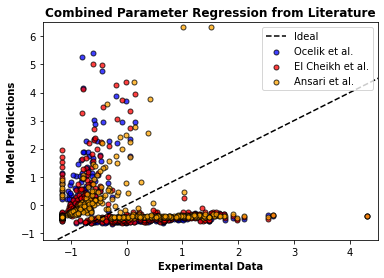

In [ ]:
plt.scatter(ARL,Ocelik, c='blue', s=25, edgecolors='k', alpha=.75)
plt.scatter(ARL,ElCh, c='red', s=25, edgecolors='k', alpha=.75)
plt.scatter(ARL,Ansari, c='orange', s=25, edgecolors='k', alpha=.75)
plt.plot([-2,12],[-2,12], '--k')
plt.title('Combined Parameter Regression from Literature', weight='bold')
plt.xlim(-1.5,4.5)
plt.ylim(-1.25,6.5)
plt.xlabel('Experimental Data', weight='bold')
plt.ylabel('Model Predictions', weight='bold')
plt.legend(('Ideal','Ocelik et al.','El Cheikh et al.', 'Ansari et al.'))
plt.savefig('ARLit.png', dpi=600)
plt.show()

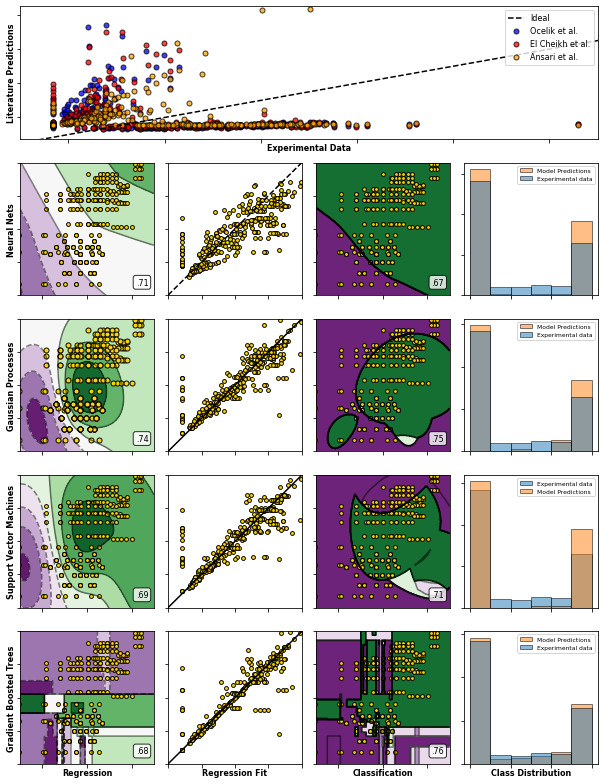

In [ ]:
fig = plt.figure(figsize=(8.5,11))
grid = fig.add_gridspec(5,4)
ax1 = fig.add_subplot(grid[0,:])
ax1.scatter(ARL,Ocelik, c='blue', s=25, edgecolors='k', alpha=.75)
ax1.scatter(ARL,ElCh, c='red', s=25, edgecolors='k', alpha=.75)
ax1.scatter(ARL,Ansari, c='orange', s=25, edgecolors='k', alpha=.75)
ax1.plot([-2,12],[-2,12], '--k')
ax1.set_xlim(-1.5,4.5)
ax1.set_ylim(-1.25,6.5)
ax1.set_xlabel('Experimental Data', weight='bold', size=8)
ax1.set_ylabel('Literature Predictions', weight='bold', size=8)
plt.legend(('Ideal','Ocelik et al.','El Cheikh et al.', 'Ansari et al.'), loc='upper right', fontsize=8)
ax1.tick_params(axis='both', labelleft=False, labelbottom=False)

ax21 = fig.add_subplot(grid[1,0])
CS21 = ax21.contourf(xx, yy, nn_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax21.contour(CS21, levels=CS21.levels, colors='k', alpha=.5)
ax21.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax21.text(2.75, -1.75, ('%.2f' % r2NN).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax21.set_xlim(-3,3)
ax21.set_ylim(-2,2)
ax21.set_ylabel('Neural Nets', weight='bold', size=8)
ax21.tick_params(axis='both', labelleft=False, labelbottom=False)
ax22 = fig.add_subplot(grid[1,1])
ax22.scatter(yr, nnr_pred, c='gold', s=15, edgecolors='k', alpha=.95)
ax22.plot([-2,2],[-2,2], '--k')
ax22.set_xlim(-2,2)
ax22.set_ylim(-2,2)
ax22.tick_params(axis='both', labelleft=False, labelbottom=False)
ax23 = fig.add_subplot(grid[1,2])
CS23 = ax23.contourf(xx, yy, nnc_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax23.contour(CS23, levels=CS23.levels, colors='k', alpha=.5)
ax23.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax23.text(2.75, -1.75, ('%.2f' % r2NNc).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax23.set_xlim(-3,3)
ax23.set_ylim(-2,2)
ax23.tick_params(axis='both', labelleft=False, labelbottom=False)
ax24 = fig.add_subplot(grid[1,3])
ax24.hist(nnc_pred, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax24.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax24.legend(('Model Predictions','Experimental data'), fontsize=6)
ax24.tick_params(axis='both', labelleft=False, labelbottom=False)

ax31 = fig.add_subplot(grid[2,0])
CS31 = ax31.contourf(xx, yy, gpr_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax31.contour(CS31, levels=CS31.levels, colors='k', alpha=.5)
ax31.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax31.text(2.75, -1.75, ('%.2f' % r2GPr).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax31.set_xlim(-3,3)
ax31.set_ylim(-2,2)
ax31.set_ylabel('Gaussian Processes', weight='bold', size=8)
ax31.tick_params(axis='both', labelleft=False, labelbottom=False)
ax32 = fig.add_subplot(grid[2,1])
ax32.scatter(yr, gpr_score, c='gold', s=15, edgecolors='k', alpha=.95)
ax32.plot([-2,2],[-2,2], c='k')
ax32.set_xlim(-2,2)
ax32.set_ylim(-2,2)
ax32.tick_params(axis='both', labelleft=False, labelbottom=False)
ax33 = fig.add_subplot(grid[2,2])
CS33 = ax33.contourf(xx, yy, gpc_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax33.contour(CS33, levels=CS33.levels, colors='k', alpha=.5)
ax33.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax33.text(2.75, -1.75, ('%.2f' % r2GPc).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax33.set_xlim(-3,3)
ax33.set_ylim(-2,2)
ax33.tick_params(axis='both', labelleft=False, labelbottom=False)
ax34 = fig.add_subplot(grid[2,3])
ax34.hist(gpc_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax34.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax34.legend(('Model Predictions','Experimental data'), fontsize=6)
ax34.tick_params(axis='both', labelleft=False, labelbottom=False)

ax41 = fig.add_subplot(grid[3,0])
CS41 = ax41.contourf(xx, yy, SVR_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax41.contour(CS41, levels=CS41.levels, colors='k', alpha=.5)
ax41.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax41.text(2.75, -1.75, ('%.2f' % r2SVR).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax41.set_xlim(-3,3)
ax41.set_ylim(-2,2)
ax41.set_ylabel('Support Vector Machines', weight='bold', size=8)
ax41.tick_params(axis='both', labelleft=False, labelbottom=False)
ax42 = fig.add_subplot(grid[3,1])
ax42.scatter(yr, svr_score, c='gold', s=15, edgecolors='k', alpha=.95)
ax42.plot([-2,2],[-2,2], c='k')
ax42.set_xlim(-2,2)
ax42.set_ylim(-2,2)
ax42.tick_params(axis='both', labelleft=False, labelbottom=False)
ax43 = fig.add_subplot(grid[3,2])
CS43 = ax43.contourf(xx, yy, SVC_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax43.contour(CS43, levels=CS43.levels, colors='k', alpha=.5)
ax43.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax43.text(2.75, -1.75, ('%.2f' % r2SVMC).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax43.set_xlim(-3,3)
ax43.set_ylim(-2,2)
ax43.tick_params(axis='both', labelleft=False, labelbottom=False)
ax44 = fig.add_subplot(grid[3,3])
ax44.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax44.hist(svmc_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax44.legend(('Experimental data','Model Predictions'), fontsize=6)
ax44.tick_params(axis='both', labelleft=False, labelbottom=False)

ax51 = fig.add_subplot(grid[4,0])
CS51 = ax51.contourf(xx, yy, rGBT_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax51.contour(CS51, levels=CS51.levels, colors='k', alpha=.5)
ax51.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax51.text(2.75, -1.75, ('%.2f' % r2rGBT).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax51.set_xlim(-3,3)
ax51.set_ylim(-2,2)
ax51.set_xlabel('Regression', weight='bold', size=8)
ax51.set_ylabel("Gradient Boosted Trees", weight='bold', size=8)
ax51.tick_params(axis='both', labelleft=False, labelbottom=False)
ax52 = fig.add_subplot(grid[4,1])
ax52.scatter(yr, rGBT_score, c='gold', s=15, edgecolors='k', alpha=.95)
ax52.plot([-2,2],[-2,2], c='k')
ax52.set_xlim(-2,2)
ax52.set_ylim(-2,2)
ax52.set_xlabel('Regression Fit', weight='bold', size=8)
ax52.tick_params(axis='both', labelleft=False, labelbottom=False)
ax53 = fig.add_subplot(grid[4,2])
CS53 = ax53.contourf(xx, yy, cGBT_y_pred.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax53.contour(CS53, levels=CS53.levels, colors='k', alpha=.5)
ax53.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=15, edgecolors='k', alpha=.95)
ax53.text(2.75, -1.75, ('%.2f' % r2cGBT).lstrip('0'), size=8,
                bbox=dict(boxstyle='round', alpha=0.8, facecolor='white'), verticalalignment='bottom', horizontalalignment='right')
ax53.set_xlim(-3,3)
ax53.set_ylim(-2,2)
ax53.set_xlabel('Classification', weight='bold', size=8)
ax53.tick_params(axis='both', labelleft=False, labelbottom=False)
ax54 = fig.add_subplot(grid[4,3])
ax54.hist(cGBT_score, bins=6, alpha=.5, density=True, color='tab:orange', edgecolor='k')
ax54.hist(yc, bins=6, alpha=.5, density=True, color='tab:blue', edgecolor='k')
ax54.set_xlabel('Class Distribution', weight='bold', size=8)
ax54.legend(('Model Predictions','Experimental data'), fontsize=6)
ax54.tick_params(axis='both', labelleft=False, labelbottom=False)
plt.savefig('AllresultsCombined.png', dpi=600)
plt.tight_layout()
plt.show()

=======================================================
Powder and Substrate Combination Dynamics
=======================================================

In [ ]:
X['Powder Material'].value_counts(), X['Substrate Material'].value_counts()

(PH13-8       143
 NiCrAlY       48
 WC-12Co       36
 316L          27
 Ti-6Al-4V     22
 Colmonoy      15
 Cobalt         9
 CuNiCo         9
 NiCr           5
 Name: Powder Material, dtype: int64, Stainless Steel    143
 Steel               74
 Inconel 738         48
 316L                27
 Ti-6Al-4V           22
 Name: Substrate Material, dtype: int64)

In [ ]:
#xx, yy = np.meshgrid(np.linspace(-3, 3, 500), np.linspace(-3, 3, 500))
#ones = np.ones((xx.ravel().shape[0],1))
PM1 = np.array(['PH13-8']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
PM2 = np.array(['316L']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
PM3 = np.array(['Ti-6Al-4V']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM1 = np.array(['Steel']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM2 = np.array(['Inconel 738']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM3 = np.array(['316L']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
SM4 = np.array(['Ti-6Al-4V']*xx.ravel().shape[0], dtype=object).reshape(-1,1)
Spot_Size = .75
DF21 = pd.DataFrame(np.column_stack(tup=[PM2, SM1, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF22 = pd.DataFrame(np.column_stack(tup=[PM2, SM2, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF23 = pd.DataFrame(np.column_stack(tup=[PM2, SM3, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF24 = pd.DataFrame(np.column_stack(tup=[PM2, SM4, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF31 = pd.DataFrame(np.column_stack(tup=[PM3, SM1, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF32 = pd.DataFrame(np.column_stack(tup=[PM3, SM2, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF33 = pd.DataFrame(np.column_stack(tup=[PM3, SM3, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
DF34 = pd.DataFrame(np.column_stack(tup=[PM3, SM4, Spot_Size*ones, ones, yy.ravel(), ones, xx.ravel()]), 
        columns=['Powder Material', 'Substrate Material','Spot Size (mm)','Power (W)', 'Mass Flowrate (g/min)',
                 'Traverse Velocity (mm/min)', 'Linear Heat Input (J/mm)'])
#Test_preprocessor.fit(X)
PS21 = Test_preprocessor.transform(DF21)
PS22 = Test_preprocessor.transform(DF22)
PS23 = Test_preprocessor.transform(DF23)
PS24 = Test_preprocessor.transform(DF24)
PS31 = Test_preprocessor.transform(DF31)
PS32 = Test_preprocessor.transform(DF32)
PS33 = Test_preprocessor.transform(DF33)
PS34 = Test_preprocessor.transform(DF34)

In [ ]:
comb1 = SVR.predict(PS21.toarray())
comb2 = SVR.predict(PS22.toarray())
comb3 = SVR.predict(PS23.toarray())
comb4 = SVR.predict(PS24.toarray())
comb5 = SVR.predict(PS31.toarray())
comb6 = SVR.predict(PS32.toarray())
comb7 = SVR.predict(PS33.toarray())
comb8 = SVR.predict(PS34.toarray())

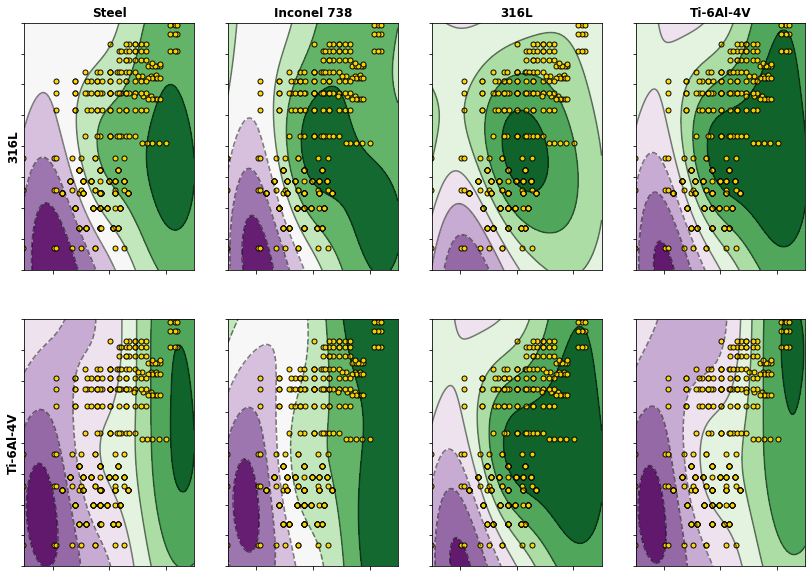

In [ ]:
fig = plt.figure(figsize=(14,10))
grid = fig.add_gridspec(2,4)
ax11 = fig.add_subplot(grid[0,0])
CS11 = ax11.contourf(xx, yy, comb1.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax11.contour(CS11, levels=CS11.levels, colors='k', alpha=.5)
ax11.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax11.set_xlim(-3,3)
ax11.set_ylim(-2,2)
ax11.set_title('Steel', weight='bold', size=12)
ax11.set_ylabel('316L', weight='bold', size=12)
ax11.tick_params(axis='both', labelleft=False, labelbottom=False)
ax12 = fig.add_subplot(grid[0,1])
CS12 = ax12.contourf(xx, yy, comb2.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax12.contour(CS12, levels=CS12.levels, colors='k', alpha=.5)
ax12.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax12.set_xlim(-3,3)
ax12.set_ylim(-2,2)
ax12.set_title('Inconel 738', weight='bold', size=12)
ax12.tick_params(axis='both', labelleft=False, labelbottom=False)
ax13 = fig.add_subplot(grid[0,2])
CS13 = ax13.contourf(xx, yy, comb3.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax13.contour(CS13, levels=CS13.levels, colors='k', alpha=.5)
ax13.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax13.set_xlim(-3,3)
ax13.set_ylim(-2,2)
ax13.set_title('316L', weight='bold', size=12)
ax13.tick_params(axis='both', labelleft=False, labelbottom=False)
ax14 = fig.add_subplot(grid[0,3])
CS14 = ax14.contourf(xx, yy, comb4.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax14.contour(CS14, levels=CS14.levels, colors='k', alpha=.5)
ax14.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax14.set_xlim(-3,3)
ax14.set_ylim(-2,2)
ax14.set_title('Ti-6Al-4V', weight='bold', size=12)
ax14.tick_params(axis='both', labelleft=False, labelbottom=False)

ax21 = fig.add_subplot(grid[1,0])
CS21 = ax21.contourf(xx, yy, comb5.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax21.contour(CS21, levels=CS21.levels, colors='k', alpha=.5)
ax21.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax21.set_xlim(-3,3)
ax21.set_ylim(-2,2)
ax21.set_ylabel('Ti-6Al-4V', weight='bold', size=12)
ax21.tick_params(axis='both', labelleft=False, labelbottom=False)
ax22 = fig.add_subplot(grid[1,1])
CS22 = ax22.contourf(xx, yy, comb6.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax22.contour(CS22, levels=CS22.levels, colors='k', alpha=.5)
ax22.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax22.set_xlim(-3,3)
ax22.set_ylim(-2,2)
ax22.tick_params(axis='both', labelleft=False, labelbottom=False)
ax23 = fig.add_subplot(grid[1,2])
CS23 = ax23.contourf(xx, yy, comb7.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax23.contour(CS23, levels=CS23.levels, colors='k', alpha=.5)
ax23.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax23.set_xlim(-3,3)
ax23.set_ylim(-2,2)
ax23.tick_params(axis='both', labelleft=False, labelbottom=False)
ax24 = fig.add_subplot(grid[1,3])
CS24 = ax24.contourf(xx, yy, comb8.reshape(xx.shape), levels=6, cmap=plt.cm.PRGn)
ax24.contour(CS24, levels=CS24.levels, colors='k', alpha=.5)
ax24.scatter(Xrc[:,2].toarray(), Xrc[:,1].toarray(), c='gold', s=25, edgecolors='k', alpha=.95)
ax24.set_xlim(-3,3)
ax24.set_ylim(-2,2)
ax24.tick_params(axis='both', labelleft=False, labelbottom=False)
plt.savefig('PowderSubDynamics.png',dpi=600)
plt.show()

=======================================================
Novelty Detection
=======================================================

In [ ]:
PosCases = FullDS[(FullDS['Aspect Ratio (H/W)']>=.475) & (FullDS['Aspect Ratio (H/W)']<=.525)]
NegCases = FullDS[(FullDS['Aspect Ratio (H/W)']<.475) | (FullDS['Aspect Ratio (H/W)']>.525)]
PosCases = PosCases.drop(columns=['Powder Material', 'Substrate Material', 'Spot Size (mm)',
                                  'Power (W)', 'Traverse Velocity (mm/min)','Aspect Ratio (H/W)'])
NegCases = NegCases.drop(columns=['Powder Material', 'Substrate Material', 'Spot Size (mm)',
                                  'Power (W)', 'Traverse Velocity (mm/min)','Aspect Ratio (H/W)'])
PC_MMS = MinMaxScaler(feature_range=(-1,1))
NC_MMS = MinMaxScaler(feature_range=(-1,1))
PC = PC_MMS.fit_transform(PosCases)
NC = NC_MMS.fit_transform(NegCases)
PC_train, PC_test = train_test_split(PC, test_size=.2)
NC_train, NC_test = train_test_split(NC, test_size=.2)

In [ ]:
xxgan, yygan = np.meshgrid(np.linspace(-1, 1, 500), np.linspace(-1, 1, 500))

In [ ]:
NDetectPos = svm.OneClassSVM(kernel='rbf',gamma='scale',nu=0.1)
#NDetectPos = IsolationForest(n_estimators=1000)
NDetectPos.fit(PC_train)
Pos_y_pred_train = NDetectPos.predict(PC_train)
Pos_y_pred_test = NDetectPos.predict(PC_test)
Pos_y_pred_outliers = NDetectPos.predict(NC)
Pos_n_error_train = Pos_y_pred_train[Pos_y_pred_train == -1].size
Pos_n_error_test = Pos_y_pred_test[Pos_y_pred_test == -1].size
Pos_n_error_outliers = Pos_y_pred_outliers[Pos_y_pred_outliers == 1].size
#ZPos = NDetectPos.decision_function(rcTest.toarray())
ZPos = NDetectPos.decision_function(np.c_[xxgan.ravel(), yygan.ravel()])
ZPos = ZPos.reshape(xxgan.shape)

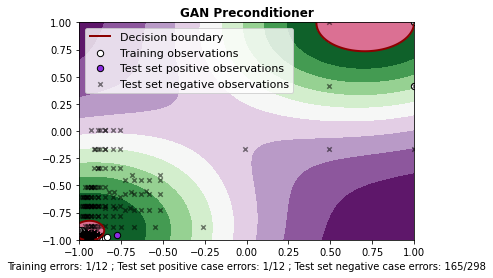

In [ ]:
plt.title("GAN Preconditioner", weight='bold')
plt.contourf(xxgan, yygan, ZPos, levels=np.linspace(ZPos.min(), 0, 10), cmap=plt.cm.PRGn)
a = plt.contour(xxgan, yygan, ZPos, levels=[0], linewidths=2, colors='darkred')
plt.contourf(xxgan, yygan, ZPos, levels=[0, ZPos.max()], colors='palevioletred')
s = 40
b1 = plt.scatter(PC_train[:,1], PC_train[:,0], c='white', s=s, edgecolors='k')
b2 = plt.scatter(PC_test[:,1], PC_test[:,0], c='blueviolet', s=s, edgecolors='k')
c = plt.scatter(NC[:,1], NC[:,0], c='k', marker='x', s=20, edgecolors='k', alpha=.5)
plt.axis('tight')
#plt.xlim((-1, -.25))
#plt.ylim((-1, -.6))
plt.legend([a.collections[0], b1, b2, c],
           ["Decision boundary", "Training observations",
            "Test set positive observations", "Test set negative observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "Training errors: %d/%d ; Test set positive case errors: %d/%d ; "
    "Test set negative case errors: %d/%d"
    % (Pos_n_error_train, PC_train.shape[0], Pos_n_error_test, PC_train.shape[0], Pos_n_error_outliers, NC.shape[0]))
plt.show()

In [ ]:
def build_generator(Latent_space,NLNodes,NumLayers,LNodes):
  Ridge = 0.0
  Lasso = 0.0
  Momentum = .09014
  Epsilon = .000577
  Alpha = .3088
  NodeShrink = .7846
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Latent_space,))
  # Nonlinear Network
  NL = layers.Dense(NLNodes, activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,NumLayers):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(LNodes,activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(2, activation='tanh', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
Jenny = build_generator(32,210,1,283)

In [ ]:
def build_discriminator(Generator_output,NLNodes,NumLayers,LNodes):
  Ridge = 0.0
  Lasso = 0.0
  Momentum = .1156
  Epsilon = .000841
  Alpha = .2029
  NodeShrink = .6985
  regRL=tf.keras.regularizers.L1L2(l1=Ridge, l2=Lasso)
  # Create Input Layer
  inputs = tf.keras.layers.Input(shape=(Generator_output,))
  # Nonlinear Network
  NL = layers.Dense(NLNodes, activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Nonlinear Network Hidden Layers
  for n in range(0,NumLayers):
    NL = layers.BatchNormalization(momentum=Momentum, epsilon=Epsilon, center=True, scale=True)(NL)
    NL = layers.Dense(np.round(NLNodes*NodeShrink), use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros', kernel_regularizer=regRL)(NL)
    NL = layers.ELU(alpha=Alpha)(NL)
  # Linear Skip Connection
  L = layers.Dense(LNodes,activation='linear', use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(inputs)
  # Create Output Layer
  x = layers.concatenate([NL, L])
  outputs = layers.Dense(1, activation=tf.keras.activations.sigmoid, use_bias=True, kernel_initializer=tf.keras.initializers.GlorotNormal(seed=21), bias_initializer='zeros')(x)
  model=tf.keras.Model(inputs=inputs,outputs=outputs)
  return model

In [ ]:
Critic = build_discriminator(2,744,1,358)

In [ ]:
Pos_bar = NDetectPos.predict(np.c_[xxgan.ravel(), yygan.ravel()])

In [ ]:
def HingeRescale(Vector):
  New_Vector = np.ones((len(Vector),1))
  for n in np.arange(0,len(Vector)):
    if Vector[n]==-1:
      New_Vector[n]=0
  return New_Vector

In [ ]:
HingeRS = HingeRescale(Pos_bar)
Combined_data = np.column_stack((xxgan.ravel(), yygan.ravel(), HingeRS))
Combined_bar = Combined_data[Combined_data[:,2]==1]
x_bar = Combined_bar[:,:2]
x_bar.shape

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, scramble):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.scramble = scramble

    def train_step(self, X):
        if isinstance(X, tuple):
            X = X[0]
        # Sample random points in the latent space
        batch_size = tf.shape(X)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake data
        generated_data = self.generator(noise, training=False)

        # Combine them with real data
        combined_data = tf.concat([X, generated_data], axis=0)

        # Assemble labels discriminating real from fake images (Instance Noise)
        true_labels = tf.keras.backend.random_binomial(shape=(batch_size,1), p=self.scramble)
        fake_labels = tf.keras.backend.random_binomial(shape=(batch_size,1), p=(1-self.scramble))
        labels = tf.concat([true_labels, fake_labels], axis=0)

        # Assemble labels discriminating real from fake images
        #labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_data, training=True)
            d_loss = self.d_loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))
        misleading_labels += 0.05 * tf.random.uniform(tf.shape(misleading_labels))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(noise, training=True), training=False)
            g_loss = self.g_loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        mean_grad = tf.zeros(())
        for grad in grads:
          mean_grad += tf.reduce_mean(grad)
        mean_grad /= len(grads)
        return {"g_loss": g_loss,"g_grads": mean_grad, "d_loss": d_loss}

In [ ]:
gan = GAN(discriminator=Critic, generator=Jenny, latent_dim=32)
PreMonitor = tf.keras.callbacks.EarlyStopping(monitor='g_grads',min_delta=1e-6,patience=150,mode='min',restore_best_weights=True)
Monitor = tf.keras.callbacks.EarlyStopping(monitor='g_grads',min_delta=1e-6,patience=1000,mode='min',restore_best_weights=True)

In [ ]:
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=.5)
gan.fit(x_bar, batch_size=32,callbacks=[PreMonitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=.6)
gan.fit(x_bar, batch_size=32,callbacks=[PreMonitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=.7)
gan.fit(x_bar, batch_size=32,callbacks=[PreMonitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=.8)
gan.fit(x_bar, batch_size=32,callbacks=[PreMonitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=.9)
gan.fit(x_bar, batch_size=32,callbacks=[PreMonitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=1)
gan.fit(x_bar, batch_size=32,callbacks=[Monitor],epochs=1500,verbose=1,shuffle=True)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00005),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    d_loss_fn=tf.keras.losses.BinaryCrossentropy(), g_loss_fn=tf.keras.losses.BinaryCrossentropy(), scramble=1)
gan.fit(PC, batch_size=2,callbacks=[Monitor],epochs=1500,verbose=1,shuffle=True)

In [ ]:
gen_data = Jenny(np.random.normal(size=[50000,32]), training=False)

In [ ]:
Critic = tf.keras.models.load_model('https://raw.githubusercontent.com/mjjuhasz/Canvasback/master/SVMCritic', compile=True)

In [ ]:
Jenny = tf.keras.models.load_model('https://raw.githubusercontent.com/mjjuhasz/Canvasback/master/SVMJenny', compile=True)

In [ ]:
Position = [-1,-.5,0,.5,1]
Distribution = ['GAN Data','Preconditioned Data']
for i, num in enumerate(Position):
  for j, dist in enumerate(Distribution):
    if j == 0:
      yvalues = gen_data[(gen_data[:,0]>=(num-.05)) & (gen_data[:,0]<=(num+.05))]
    else:
      yvalues = x_bar[(x_bar[:,0]>=(num-.05)) & (x_bar[:,0]<=(num+.05))]
    #yvalues = yvalues.astype(float)
    place = np.ones((yvalues.shape[0],1),dtype=int)*num
    distro = np.array([Distribution[j]]*yvalues.shape[0], dtype=object).reshape(-1,1)
    stack = np.column_stack((place,distro,yvalues))
    if (i == 0) and (j == 0):
      finalfig = stack
    else:
      finalfig = np.concatenate((finalfig,stack))
finalfigdf = pd.DataFrame(finalfig, columns=['Position','Distribution','X-values','Y-values'])
finalfigdf['Position'] = pd.to_numeric(finalfigdf['Position'])
finalfigdf['X-values'] = pd.to_numeric(finalfigdf['X-values'])
finalfigdf['Y-values'] = pd.to_numeric(finalfigdf['Y-values'])

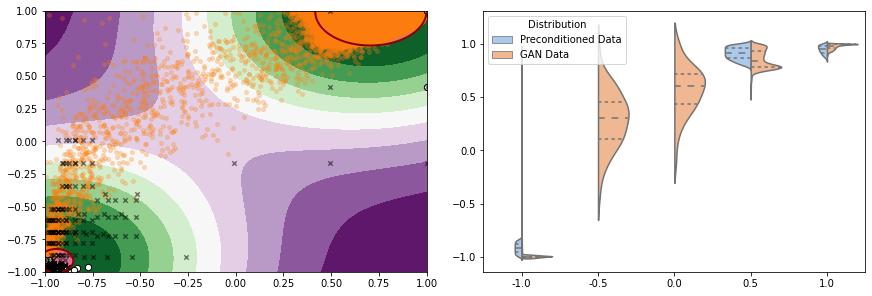

In [ ]:
fig = plt.figure(figsize=(12,4),constrained_layout=True)
grid = fig.add_gridspec(1,2)
ax1 = fig.add_subplot(grid[0,0])
#ax1.set_aspect(1/2)
ax1.contourf(xxgan, yygan, ZPos, levels=np.linspace(ZPos.min(), 0, 10), cmap=plt.cm.PRGn)
ax1.contour(xxgan, yygan, ZPos, levels=[0], linewidths=2, colors='darkred')
ax1.contourf(xxgan, yygan, ZPos, levels=[0, ZPos.max()], colors='palevioletred')
a = ax1.scatter(gen_data[:,0], gen_data[:,1], c='tab:orange', s=15, alpha=.25)
#ax1.contour(xxgan, yygan, DD, levels=[.95], linewidths=2, colors='darkblue')
#ax1.contourf(xxgan, yygan, ZPos, levels=[0, ZPos.max()], colors='palevioletred')
b = ax1.scatter(PC[:,1], PC[:,0], c='white', s=40, edgecolors='k')
c = ax1.scatter(NC[:,1], NC[:,0], c='k', marker='x', s=20, edgecolors='k', alpha=.5)
#plt.xlim((-1, -.25))
#plt.ylim((-1, -.6))
ax2 = fig.add_subplot(grid[0,1])
sns.violinplot(x='Position', y='Y-values', hue='Distribution',hue_order=['Preconditioned Data','GAN Data'] ,
               data=finalfigdf, split=True, bw='scott',palette='pastel',inner='quartile')
plt.xlabel('')
plt.ylabel('')
#plt.savefig('GANResults.png', dpi=600)
plt.show()